# Module 2a - Clip WaPOR data to Area of Interest (AOI)
This Notebook contains the following steps
* Step a - Import modules/libraries
* Step b - Clip WaPOR data to boundary (using shapefile)
* Step c - Mask WaPOR data (using land cover map) (not yet included)

**=====================================================================================================================**

![title](https://raw.githubusercontent.com/wateraccounting/WaPORIPA/main/images/Clip_image.png)

**=====================================================================================================================**

Before you start running this Notebook, make sure you have the following information:

*   Seasonal outputs from module 1 (AETI, T, TBP) and module 2 (RET, PCP, potET)

*   Shapefile with the Area of Interest (AOI)

## Step a - Import modules/libraries

In [137]:
!pip install --upgrade rioxarray --quiet

In [138]:
import os                             # a module for interacting with the operating system
import glob                           # used to retrieve files/pathnames matching a specified pattern
import matplotlib.pyplot as plt       # is a plotting library used for 2D graphics in python
import numpy as np                    # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rioxr
import rasterio as rio
import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import calendar
import datetime

from osgeo import ogr, gdal
import subprocess




# Step b - Clip using project boundary



### Poject boundary  --- convert shapefile to raster

In [ ]:
#To upload boundary shape file.
from google.colab import files
uploaded = files.upload()

''

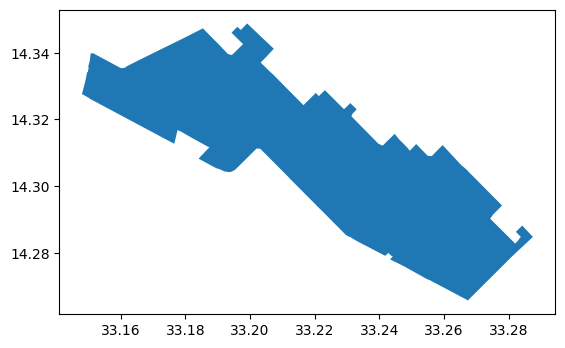

In [155]:
#show shapefile
gdf = gpd.read_file('/content/Wad_Helal.shp')
# Plotting the area
gdf.plot()
gdf
,

In [142]:
# read shapefile and reference raster files

InputVector = r"/content/Wad_Helal.shp"             # the shapefile of the project
RefImage    = r"/content/Season/bb_L2-AETI-A_NONE_year_2018-01-01.tif" # Reference raster to fix the the pixel size
OutputImage = r'/content/Wad_Helal_masked'            # name the output raster file
burnVal     = 1                                                         #value for the output image pixels

In [ ]:
# A script to rasterise a shapefile to the same projection & pixel resolution as a reference image.
gdalformat = 'GTiff'
datatype = gdal.GDT_Byte


##########################################################
# Get projection info from reference image
Image = gdal.Open(RefImage, gdal.GA_ReadOnly)

# Open Shapefile
Shapefile = ogr.Open(InputVector)
Shapefile_layer = Shapefile.GetLayer()

# Rasterise
print("Rasterising shapefile...")
Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=LZW'])
Output.SetProjection(Image.GetProjectionRef())
Output.SetGeoTransform(Image.GetGeoTransform())

# Write data to band 1
Band = Output.GetRasterBand(1)
Band.SetNoDataValue(0)
gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

# Close datasets
Band = None
Output = None
Image = None
Shapefile = None

# Build image overviews
subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+OutputImage+" 2 4 8 16 32 64", shell=True)
print("Done.")

In [ ]:
OutputImage

## i) Import the data to clip

Load all seasonal files into one folder called *Season*

In [ ]:

# Assign location of files and area to clip to

input_folderSeason  = '/content/Season'
input_fhsSeason     = glob.glob(input_folderSeason + '/*.tif')

ProArea = gis.OpenAsArray(r'/content/Wad_Helal_masked', nan_values=True)  # the project boundary/area (tif)
input_fhsSeason

## ii) Output folder: Make one or connect to the existing one

In [ ]:
output_folderSeason    = '/content/Season_clipped'


## Make one if the folder does not exit
if not os.path.exists(output_folderSeason):
    os.makedirs(output_folderSeason)

output_folderSeason

#### Plot project area

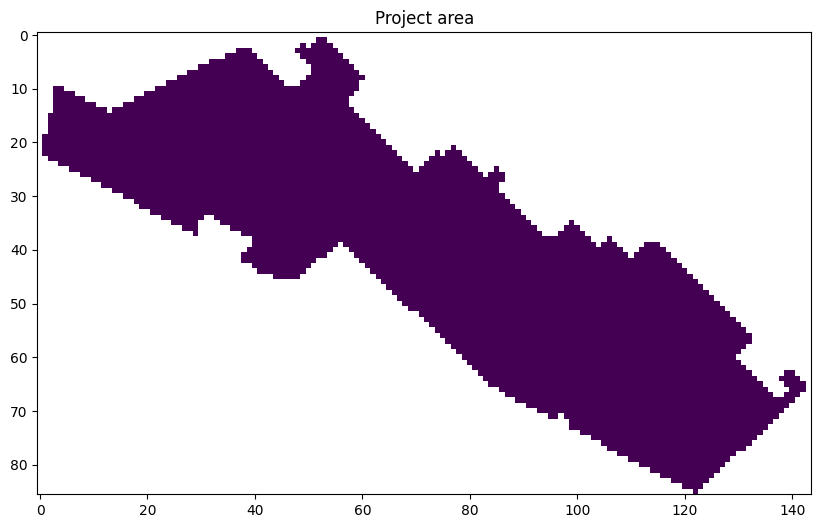

In [156]:
### Plot project area
Projectboundary = ProArea

# Plot
plt.figure(figsize = (12,6))
plt.imshow(Projectboundary)
plt.title('Project area')
plt.show();

###Clipping Seasonal layers

#### Check raster layer (before clipping to the project area)

In [ ]:
input_fhsSeason[0]

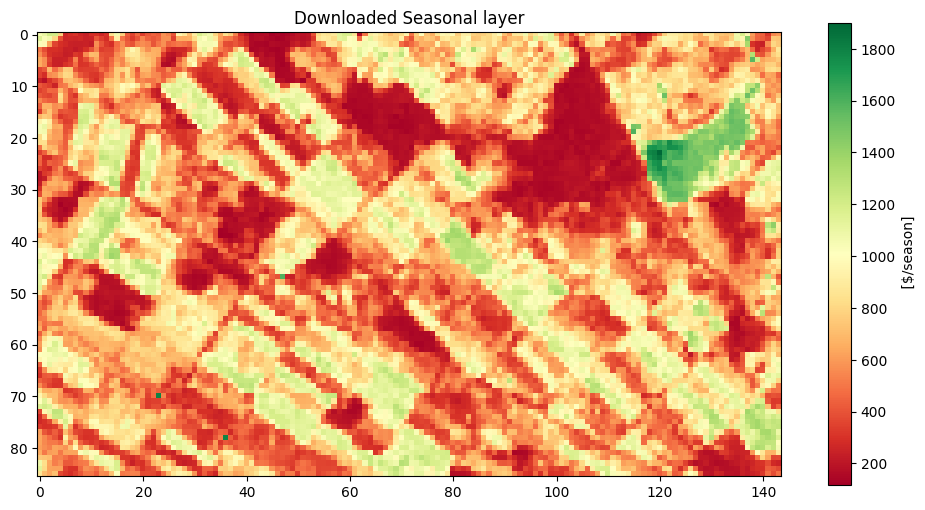

In [157]:
# Plot Seasonal layer
Season_tif = gis.OpenAsArray(input_fhsSeason[0],nan_values=True)

plt.figure(figsize = (12,8))
plt.imshow(Season_tif, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label=' [$/season]')
plt.title('Downloaded Seasonal layer')
plt.show()

####Filtering Seasonal layers



In [152]:
# collecting Geoinfo such as projection, the x and y axis
in_fh = input_fhsSeason[0]
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for Seasonfh in input_fhsSeason:
    Season = gis.OpenAsArray(Seasonfh, nan_values=True)
    Season   = np.where((ProArea==1),Season,np.nan)

    # update the file name, and save into output folder
    basename  = os.path.basename(Seasonfh)
    output_fn = os.path.join(output_folderSeason, basename)
    gis.CreateGeoTiff(output_fn, Season, driver, NDV, xsize, ysize, GeoT, Projection)

#### Check Seasonal raster layer (after clipping to the project area)




In [ ]:
output_fhsSeason = glob.glob(output_folderSeason + '/*.tif')
output_fhsSeason[0]

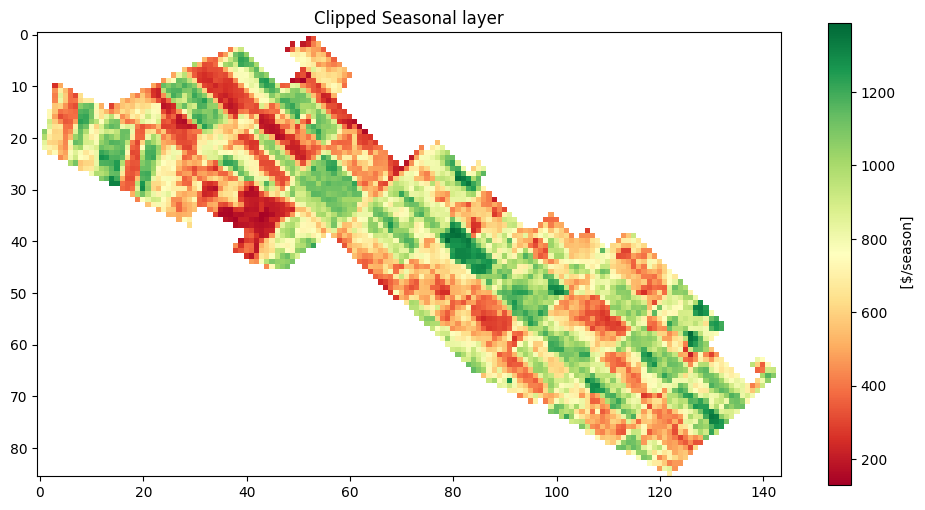

In [158]:
#visualise the raster output
output_fhsSeason     = glob.glob(output_folderSeason + '/*.tif')
PCP_tif = gis.OpenAsArray(output_fhsSeason[0],nan_values=True)      # Path to seasonal file
plt.figure(figsize = (12,8))
plt.imshow(PCP_tif, cmap='RdYlGn')
plt.colorbar(shrink=0.75, label=' [$/season]')
plt.title('Clipped Seasonal layer')
plt.show()